In [31]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Soft-Labels

Advantage of Soft-Labels compared to Hard-Labels:
1. If reviewer disagree, which the do in the provided dataset, than the soft labels show the dispersion directly (e.g. [0.4, 0.4, 0.2]) while hard labels force a decision for one class which means a loss of information. 
2. Soft-Labels create a continues target-distribution during training which enables the model to get smoother gradients then it would get with 0/1 feedback 
3. Soft-Label work against overfitting since the model can then no longer rely on the one perhaps unsafe dominant class
Disadvantage
1. Need more or at least 2 individuell labels per image for the soft-labels to work

Advantage of Soft-Labels compared to Multiple-Hard-Labels:
1. Taking images multiple time into training (in one epoch) with different labels has the disadvantage that the model see the images multiple times and could think that those images are more important 
2. Futhermore the contradictory feedback could make the gradients of the model unstable and hinder the learning process

In [27]:
def calculate_mgs(row: pd.Series, reviewer_id: int, fau_keys: list) -> float:
    """
    Calculate the MGS value for a given row and reviewer ID.
    """
    # if orbital tighening is not set than the review will be seen as not valid just like Dr. Katharina Hohlbaum told us
    # since orbital tightening is one of the most important facual action units for the MGS
    if pd.isna(row.get(f"ot{reviewer_id}")):
        return np.nan
    
    fau_values = []
    for key in fau_keys:
        fau_value = row.get(f"{key}{reviewer_id}")
        if pd.notna(fau_value):
            fau_values.append(int(fau_value))
    
    if len(fau_values) == 0:
        return np.nan
    
    return round(np.mean(fau_values))

In [ ]:
path = Path(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\labels\v3_mgs_01.csv")
df = pd.read_csv(path, sep=",")
df.replace(["-", "9"], np.nan, inplace=True)

reviewer_id = list(range(1, 13))
fau_keys = ["ot", "nb", "cb", "ep", "wc"]

output_rows = []
number_of_mgs_values = {}
number_of_no_mgs_values, no_mgs_image_names = 0, []
dominant_mgs_values = {}
for idx, row in df.iterrows():
    image_name = row["index"]
    mgs_values = [calculate_mgs(row, reviewer_id, fau_keys) for reviewer_id in reviewer_id]
    mgs_values = [value for value in mgs_values if pd.notna(value)]
    
    if len(mgs_values) == 0: 
        number_of_no_mgs_values += 1
        no_mgs_image_names.append(image_name)
        continue

    counts = np.bincount(mgs_values, minlength=6)
    soft_labels = counts / counts.sum()
    
    # check how many images have the same number of valid MGS reviews
    if counts.sum() in number_of_mgs_values:
        number_of_mgs_values[counts.sum()] += 1
    else:
        number_of_mgs_values[counts.sum()] = 1
    
    # check which MGS value is the most dominant one
    dominant_mgs = np.argmax(counts)
    if dominant_mgs in dominant_mgs_values:
        dominant_mgs_values[dominant_mgs] += 1
    else:
        dominant_mgs_values[dominant_mgs] = 1
    
    output_rows.append({
        "index": image_name,
        "mgs_0": soft_labels[0],
        "mgs_1": soft_labels[1],
        "mgs_2": soft_labels[2],
    })

# # Create a CSV file with the soft labels   
# soft_labels_df = pd.DataFrame(output_rows)
# soft_labels_df.set_index("index", inplace=True)
# soft_labels_df.to_csv(path.parent / "mgs_soft_labels.csv", sep=",")

Number of images with no MGS reviews: 33
Images with no MGS reviews: ['005360.jpg', '005372.jpg', '006739.jpg', '007853.jpg', '009205.jpg', '009602.jpg', '009843.jpg', '010554.jpg', '011100.jpg', '012070.jpg', '012098.jpg', '012605.jpg', '013039.jpg', '014744.jpg', '014890.jpg', '017103.jpg', '017165.jpg', '017543.jpg', '018245.jpg', '022322.jpg', '022330.jpg', '022718.jpg', '023282.jpg', '023995.jpg', '024103.jpg', '024490.jpg', '024652.jpg', '025799.jpg', '025832.jpg', '027152.jpg', '027354.jpg', '027960.jpg', '028133.jpg']
{np.int64(2): 515, np.int64(1): 662, np.int64(4): 608, np.int64(3): 1586, np.int64(5): 9}


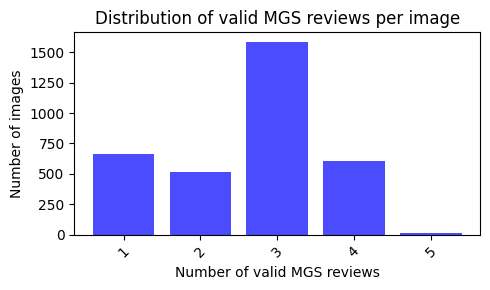

In [ ]:
print(f"Number of images with no MGS reviews: {number_of_no_mgs_values}")
print(f"Images with no MGS reviews: {no_mgs_image_names}")
print(number_of_mgs_values)

plt.figure(figsize=(5, 3))
plt.bar(number_of_mgs_values.keys(), number_of_mgs_values.values(), color='blue', alpha=0.7)
plt.xlabel("Number of valid MGS reviews")
plt.ylabel("Number of images")
plt.title("Distribution of valid MGS reviews per image")
plt.xticks(list(number_of_mgs_values.keys()), rotation=45)
plt.tight_layout()
plt.show()

- `2718` out of `3407` labels images have at least to valid MGS reviews -> It is usefull to apply soft labels 
- `33` images doesn't have at least one valid review

## Class inbalances with Soft-Label approach

{np.int64(1): 1255, np.int64(0): 2027, np.int64(2): 98}


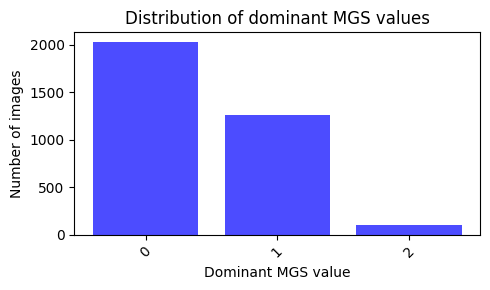

In [ ]:
print(dominant_mgs_values)
plt.figure(figsize=(5, 3))
plt.bar(dominant_mgs_values.keys(), dominant_mgs_values.values(), color='blue', alpha=0.7)
plt.xlabel("Dominant MGS value")
plt.ylabel("Number of images")
plt.title("Distribution of dominant MGS values")
plt.xticks(list(dominant_mgs_values.keys()), rotation=45)
plt.tight_layout()
plt.show()


In [52]:
class_freq = np.array(list(dominant_mgs_values.values())) / sum(dominant_mgs_values.values())
inverted_class_freq = 1 / class_freq
inverted_class_freq = inverted_class_freq / sum(inverted_class_freq)  # Normalize to sum to 1

print(f"Class frequencies: {class_freq}")
print(f"Inverted class frequencies: {inverted_class_freq} to use as weights for the loss function")

Class frequencies: [0.37130178 0.59970414 0.02899408]
Inverted class frequencies: [0.06932282 0.04292064 0.88775654] to use as weights for the loss function


- In nearly 60% of the images have a dominant 0 labels, meaning that in nearly 60% of the images does the mice doesn't have much pain occording to the reviewers
- In over 37% the mice seem to have some pain
- In only 3% the mice are considered to have great pain

-> Obvious class imbalance which has to be dealt with

To balance the classes their must be a weightening of the losses while training. The following sources suggest using a modified version of the CrossEntropyLoss like seen in the code snipped below.
- [Mastering Soft Labeling for Noisy Datasets: A Practical Guide](https://medium.com/@whyamit404/mastering-soft-labeling-for-noisy-datasets-a-practical-guide-76222e021091)
- [Stackoverflow: Weighted Soft CrossEntropyLoss in Pytorch](https://stackoverflow.com/questions/68907809/soft-cross-entropy-in-pytorch/68914806#68914806)
- [Stackoverflow: How to use soft labels in computer vision with PyTorch?](https://stackoverflow.com/questions/69530476/how-to-use-soft-labels-in-computer-vision-with-pytorch)

In [ ]:
class SoftCrossEntropyLoss():
   def __init__(self, weights):
      super().__init__()
      self.weights = weights

   def forward(self, y_hat, y):
       # logits / y_hat: [batch_size, num_classes] - unscaled predictions
       # y: [batch_size, num_classes] - soft labels
       # weights: [num_classes] - weights for each class
      p = F.log_softmax(y_hat, 1)
      w_labels = self.weights*y
      loss = -(w_labels*p).sum() / (w_labels).sum()
      return loss

# Hard-Labels

In [ ]:
def safe_mean(row, columns):
    values = row[columns]
    str_values = values.astype(str)
    
    if "-" in str_values.values:
        if any(v in ["0", "1", "2"] for v in str_values.values):
            raise ValueError(f"Invalid mix of numbers and '-' in row {row.name}")
        values = values.replace("-", np.nan)

    
    values = pd.to_numeric(values, errors='coerce')
    if values.isna().all():
        return np.nan
    else:
        values = values.replace(9, np.nan)
        return values.mean(axis=0, skipna=True)

def create_mgs_labels(
    mgs_path: Path,
) -> None:
    """
    The function tasks a CSV file containing the five facial action unit (FAU) values from different reviewers on the the mice images in the dataset 
    and creates a new CSV file ('labels.csv') which only contains the filename of the images and their corresponding label (accumulated and averaged MGS score) 
    
    | filename   | label |
    |------------|-------|
    | img0.jpg   | 0     |
    | img1.png   | 1     |
    | ...        | ...   |

    """
    
    reviewer_columns = [
        ['ot1', 'nb1', 'cb1', 'ep1', 'wc1'],
        ['ot2', 'nb2', 'cb2', 'ep2', 'wc2'],
        ['ot3', 'nb3', 'cb3', 'ep3', 'wc3'],
        ['ot4', 'nb4', 'cb4', 'ep4', 'wc4'],
        ['ot5', 'nb5', 'cb5', 'ep5', 'wc5'],
        ['ot6', 'nb6', 'cb6', 'ep6', 'wc6'],
        ['ot7', 'nb7', 'cb7', 'ep7', 'wc7'],
        ['ot9', 'nb9', 'cb9', 'ep9', 'wc9'],
        ['ot10', 'nb10', 'cb10', 'ep10', 'wc10'],
        ['ot11', 'nb11', 'cb11', 'ep11', 'wc11'],
        ['ot12', 'nb12', 'cb12', 'ep12', 'wc12']
    ]
    
    df = pd.read_csv(mgs_path)
    for i, columns in enumerate(reviewer_columns):
        df[f'mgs_reviewer{i+1}'] = df.apply(lambda row: safe_mean(row, columns), axis=1)
    df = df[['index'] + [f'mgs_reviewer{i+1}' for i in range(len(reviewer_columns))]]

    
    reviewer_cols = [col for col in df.columns if col.startswith('mgs_reviewer')]
    df['mgs_mean'] = df[reviewer_cols].mean(axis=1, skipna=True)
    df['mgs_mean_rounded'] = df['mgs_mean'].round()
    df = df[['index', 'mgs_mean_rounded']]
    df.to_csv(
        mgs_path.parent / "labels.csv",
        index=False,
        header=["filename", "label"],
    )

mgs_path = Path(r"C:\Users\Freun\Desktop\htcv_mgs\data\MGS_data\labels\v3_mgs_01.csv")
create_mgs_labels(mgs_path)